# Evaluate RegNet model offline

Let’s start by loading our trained model and our test data.

In [ ]:
!pip install torch torchvision pandas numpy matplotlib seaborn pillow torchsummary scikit-learn grad-cam

In [2]:
#imports
import os
import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader, Dataset, Subset
from torchsummary import summary
from sklearn.model_selection import StratifiedKFold
# runs in jupyter container on node-eval-offline
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [3]:
# @TODO: chnage Model Path
# model_path = "/Users/manali/nyu/COURSES/Sem4/MLOps/serving/inference_service/model.pth" 
# model_path = "/Users/manali/nyu/COURSES/Sem4/MLOps/serving/models/checkpoint.pth"
model_path = "../inference_service/model.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(model_path, map_location=device, weights_only=False)
_ = model.eval()  

In [4]:
# Preprocess Images
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = csv_file
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(int(self.annotations.iloc[idx, 1]))
        if self.transform:
            image = self.transform(image)
        return image, label

def create_dataloaders(csv_file, img_dir, img_size=(224, 224), batch_size=32, n_fold=0):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip()
    ])

    dataset = CustomImageDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
    for i, (train_index, val_index) in enumerate(skf.split(np.zeros(len(csv_file)), csv_file.iloc[:, 1].values)):
        if i == n_fold:
            break

    train_dataset = Subset(dataset, train_index)
    dataset = CustomImageDataset(csv_file=csv_file, img_dir=img_dir,
                               transform=transforms.Compose([
                                   transforms.Resize(img_size),
                                   transforms.ToTensor()
                               ]))
    val_dataset = Subset(dataset, val_index)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader

In [5]:
# @TODO: Change Paths
# csv_file = pd.read_csv("/Users/manali/nyu/COURSES/Sem4/MLOps/serving/AiVsHuman/validation.csv")
# img_dir="/Users/manali/nyu/COURSES/Sem4/MLOps/serving/AiVsHuman/Images"
csv_file = pd.read_csv("/mnt/data/AiVsHuman/validation.csv")
img_dir="/mnt/data/AiVsHuman/Images"

In [6]:
# Load preprocessed data 
train_loader, val_loader = create_dataloaders(
        csv_file=csv_file,
        img_dir=img_dir,
        img_size=(224,224),
        batch_size=32,
        n_fold=0
    )

In [7]:
# # food_11_data_dir = os.getenv("FOOD11_DATA_DIR", "Food-11")
# data_dir = "./AiVsHuman/Images"
# val_test_transform = transforms.Compose([
#         transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
#         transforms.RandomCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225]),
# ])
# test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'validation'), transform=val_test_transform)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Evaluate model on general metrics for its domain

In this case, our model is a classification model, so we will compute accuracy.

To start, let’s get the predictions of the model on the held-out test set:

In [7]:
dataset_size = len(val_loader.dataset)
all_predictions = np.empty(dataset_size, dtype=np.int64)
all_labels = np.empty(dataset_size, dtype=np.int64)
current_index = 0

with torch.no_grad():
    for images, labels in val_loader:
        batch_size = labels.size(0)

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_predictions[current_index:current_index + batch_size] = predicted.cpu().numpy()
        all_labels[current_index:current_index + batch_size] = labels.cpu().numpy()
        current_index += batch_size


## Compute the overall accuracy:

In [8]:
overall_accuracy = (all_predictions == all_labels).sum() / all_labels.shape[0] * 100
print(f'Overall Accuracy: {overall_accuracy:.2f}%')


Overall Accuracy: 55.16%


We can also compute the per-class accuracy. It would be concerning if our classifier had very low accuracy for some classes, even if it has high accuracy for others. We might set a criteria that e.g. the model we deploy must have a minimum overall accuracy, and then a different minimum per-class accuracy for all classes.

In [9]:
classes = np.array(["Human","AI"])
num_classes = classes.shape[0]

In [10]:
per_class_correct = np.zeros(num_classes, dtype=np.int32)
per_class_total = np.zeros(num_classes, dtype=np.int32)

for true_label, pred_label in zip(all_labels, all_predictions):
    per_class_total[true_label] += 1
    per_class_correct[true_label] += int(true_label == pred_label)

for i in range(num_classes):
    if per_class_total[i] > 0:
        acc = per_class_correct[i] / per_class_total[i] * 100
        correct_str = f"{per_class_correct[i]}/{per_class_total[i]}"
        print(f"{classes[i]:<20} {acc:10.2f}% {correct_str:>20}")

Human                    100.00%              800/800
AI                        10.26%               82/799


And, we can use a confusion matrix:

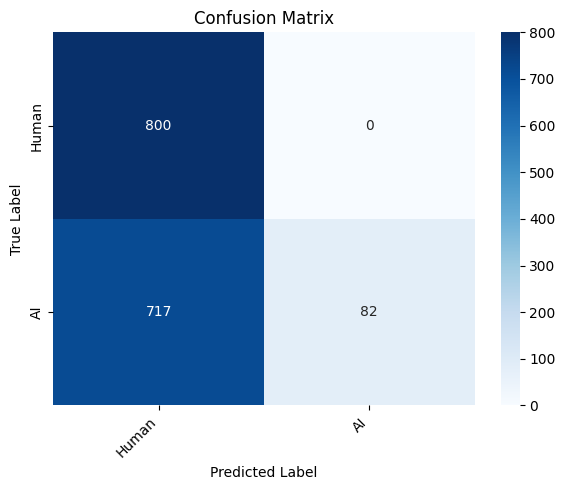

In [11]:
conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
for true_label, pred_label in zip(all_labels, all_predictions):
    conf_matrix[true_label, pred_label] += 1

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Use human judgement and explainable AI techniques to “sanity check” a model

Let’s use our human judgement to better understand some of these errors.

In [12]:
ai_index = np.where(classes == "AI")[0][0]
human_index = np.where(classes == "Human")[0][0]

#### Images that are AI but predicted as Human

In [13]:
confused_indices_ai = [i for i, (t, p) in enumerate(zip(all_labels, all_predictions))
                    if (t == ai_index and p == human_index)]

sample_indices_confused_ai = np.random.choice(confused_indices_ai, size=min(5, len(confused_indices_ai)), replace=False)

sample_images_confused_ai = []
start_idx = 0
for images, _ in val_loader:
    batch_size = images.size(0)
    end_idx = start_idx + batch_size
    for idx in sample_indices_confused_ai:
        if start_idx <= idx < end_idx:
            image = images[idx - start_idx].cpu()
            sample_images_confused_ai.append((idx, image))
    start_idx = end_idx
    if len(sample_images_confused_ai) == len(sample_indices_confused_ai):
        break

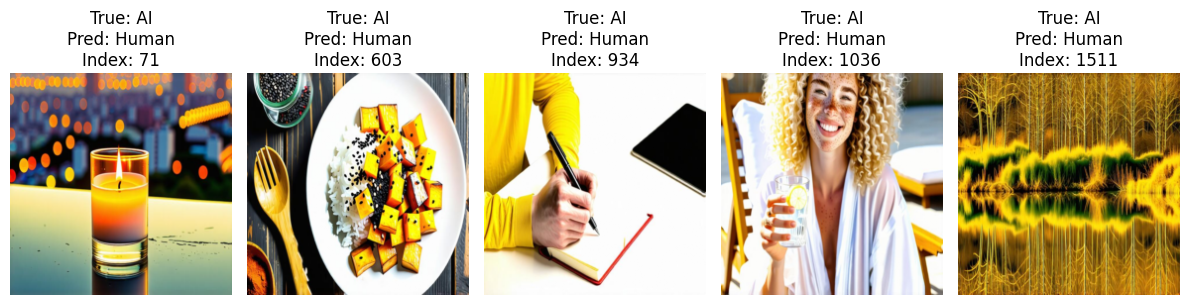

In [14]:
# mean = torch.tensor([0.485, 0.456, 0.406])
# std = torch.tensor([0.229, 0.224, 0.225])

# Visualize those samples (undo the normalization first)
plt.figure(figsize=(12, 3))
for i, (idx, image) in enumerate(sample_images_confused_ai):
    # image = image * std[:, None, None] + mean[:, None, None]  # unnormalize
    image = torch.clamp(image, 0, 1)
    image = image.permute(1, 2, 0)  # go from "channels, height, width" format to "height, width, channels"
    plt.subplot(1, len(sample_images_confused_ai), i + 1)
    plt.imshow(image)
    plt.title(f"True: {classes[all_labels[idx]]}\nPred: {classes[all_predictions[idx]]}\nIndex: {idx}")
    plt.axis('off')
plt.tight_layout()
plt.show()

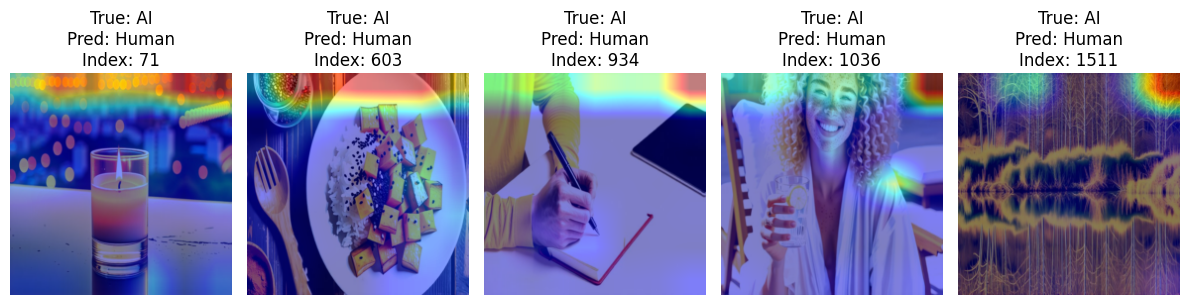

In [15]:
target_layers = [model.trunk_output.block4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

plt.figure(figsize=(12, 3))
for i, (idx, image) in enumerate(sample_images_confused_ai):
    # input_tensor = (image.clone() - mean[:, None, None]) / std[:, None, None]  # normalize
    input_tensor = image.clone()
    input_tensor = input_tensor.unsqueeze(0)  # add batch dim

    target_category = int(all_predictions[idx])
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(target_category)])
    grayscale_cam = grayscale_cam[0, :]

    image_disp = image # * std[:, None, None] + mean[:, None, None]  # unnormalize
    image_disp = torch.clamp(image_disp, 0, 1).permute(1, 2, 0).numpy()

    visualization = show_cam_on_image(image_disp, grayscale_cam, use_rgb=True)
    plt.subplot(1, len(sample_images_confused_ai), i + 1)
    plt.imshow(visualization)
    plt.title(f"True: {classes[all_labels[idx]]}\nPred: {classes[all_predictions[idx]]}\nIndex: {idx}")
    plt.axis('off')
plt.tight_layout()
plt.show()

#### Images that are Human but predicted as AI

In [16]:
confused_indices_human = [i for i, (t, p) in enumerate(zip(all_labels, all_predictions))
                    if (t == human_index and p == ai_index)]

sample_indices_confused_human = np.random.choice(confused_indices_human, size=min(5, len(confused_indices_human)), replace=False)

sample_images_confused_human = []
start_idx = 0
for images, _ in val_loader:
    batch_size = images.size(0)
    end_idx = start_idx + batch_size
    for idx in sample_indices_confused_human:
        if start_idx <= idx < end_idx:
            image = images[idx - start_idx].cpu()
            sample_images_confused_human.append((idx, image))
    start_idx = end_idx
    if len(sample_images_confused_human) == len(sample_indices_confused_human):
        break

In [17]:
plt.figure(figsize=(12, 3))
for i, (idx, image) in enumerate(sample_images_confused_human):
    image = torch.clamp(image, 0, 1)
    image = image.permute(1, 2, 0) 
    plt.subplot(1, len(sample_images_confused_human), i + 1)
    plt.imshow(image)
    plt.title(f"True: {classes[all_labels[idx]]}\nPred: {classes[all_predictions[idx]]}\nIndex: {idx}")
    plt.axis('off')
plt.tight_layout()
plt.show()

<Figure size 1200x300 with 0 Axes>

In [18]:
target_layers = [model.trunk_output.block4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

plt.figure(figsize=(12, 3))
for i, (idx, image) in enumerate(sample_images_confused_human):
    # input_tensor = (image.clone() - mean[:, None, None]) / std[:, None, None]  # normalize
    input_tensor = image.clone()
    input_tensor = input_tensor.unsqueeze(0)  # add batch dim

    target_category = int(all_predictions[idx])
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(target_category)])
    grayscale_cam = grayscale_cam[0, :]

    image_disp = image # * std[:, None, None] + mean[:, None, None]  # unnormalize
    image_disp = torch.clamp(image_disp, 0, 1).permute(1, 2, 0).numpy()

    visualization = show_cam_on_image(image_disp, grayscale_cam, use_rgb=True)
    plt.subplot(1, len(sample_images_confused_human), i + 1)
    plt.imshow(visualization)
    plt.title(f"True: {classes[all_labels[idx]]}\nPred: {classes[all_predictions[idx]]}\nIndex: {idx}")
    plt.axis('off')
plt.tight_layout()
plt.show()

<Figure size 1200x300 with 0 Axes>

#### Images that are Human and correctly predicted as human

In [19]:
indices_truly_human = [i for i, (t, p) in enumerate(zip(all_labels, all_predictions))
                    if (t == human_index and p == human_index)]
sample_indices_truly_human = np.random.choice(indices_truly_human, size=min(5, len(indices_truly_human)), replace=False)

sample_images_truly_human = []
start_idx = 0
for images, _ in val_loader:
    batch_size = images.size(0)
    end_idx = start_idx + batch_size
    for idx in sample_indices_truly_human:
        if start_idx <= idx < end_idx:
            image = images[idx - start_idx].cpu()
            sample_images_truly_human.append((idx, image))
    start_idx = end_idx
    if len(sample_images_truly_human) == len(sample_indices_truly_human):
        break



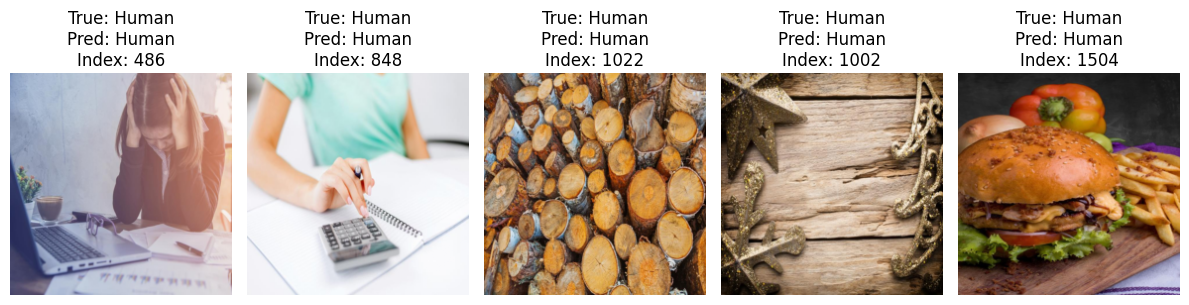

In [20]:
plt.figure(figsize=(12, 3))
for i, (idx, image) in enumerate(sample_images_truly_human):
    image = torch.clamp(image, 0, 1)
    image = image.permute(1, 2, 0) 
    plt.subplot(1, len(sample_images_truly_human), i + 1)
    plt.imshow(image)
    plt.title(f"True: {classes[all_labels[idx]]}\nPred: {classes[all_predictions[idx]]}\nIndex: {idx}")
    plt.axis('off')
plt.tight_layout()
plt.show()

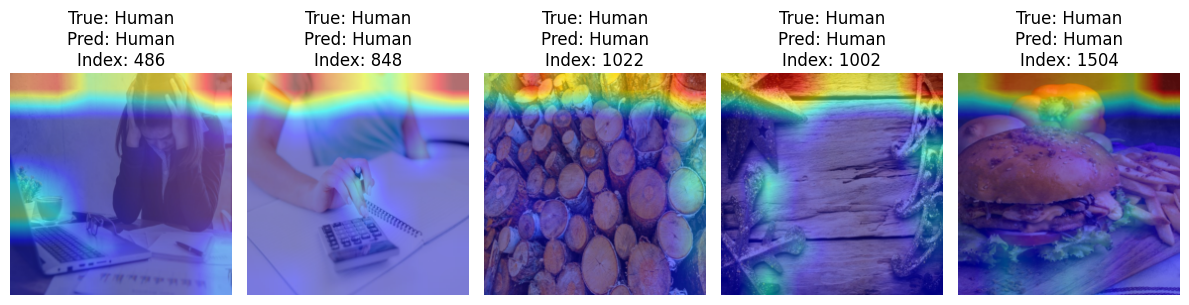

In [21]:
target_layers = [model.trunk_output.block4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

plt.figure(figsize=(12, 3))
for i, (idx, image) in enumerate(sample_images_truly_human):
    # input_tensor = (image.clone() - mean[:, None, None]) / std[:, None, None]  # normalize
    input_tensor = image.clone()
    input_tensor = input_tensor.unsqueeze(0)  # add batch dim

    target_category = int(all_predictions[idx])
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(target_category)])
    grayscale_cam = grayscale_cam[0, :]

    image_disp = image # * std[:, None, None] + mean[:, None, None]  # unnormalize
    image_disp = torch.clamp(image_disp, 0, 1).permute(1, 2, 0).numpy()

    visualization = show_cam_on_image(image_disp, grayscale_cam, use_rgb=True)
    plt.subplot(1, len(sample_images_truly_human), i + 1)
    plt.imshow(visualization)
    plt.title(f"True: {classes[all_labels[idx]]}\nPred: {classes[all_predictions[idx]]}\nIndex: {idx}")
    plt.axis('off')
plt.tight_layout()
plt.show()

#### Images that are AI and correctly predicted as AI

In [22]:
indices_truly_ai = [i for i, (t, p) in enumerate(zip(all_labels, all_predictions))
                    if (t == ai_index and p == ai_index)]
sample_indices_truly_ai = np.random.choice(indices_truly_ai, size=min(5, len(indices_truly_ai)), replace=False)

sample_images_truly_ai = []
start_idx = 0
for images, _ in val_loader:
    batch_size = images.size(0)
    end_idx = start_idx + batch_size
    for idx in sample_indices_truly_ai:
        if start_idx <= idx < end_idx:
            image = images[idx - start_idx].cpu()
            sample_images_truly_ai.append((idx, image))
    start_idx = end_idx
    if len(sample_images_truly_ai) == len(sample_indices_truly_ai):
        break



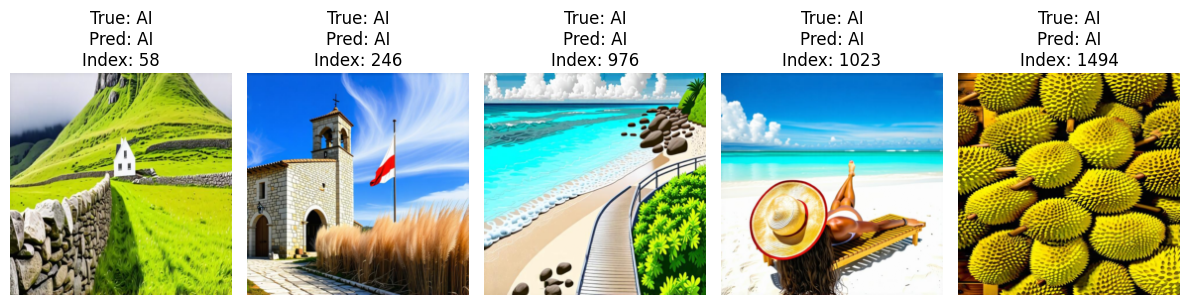

In [23]:
plt.figure(figsize=(12, 3))
for i, (idx, image) in enumerate(sample_images_truly_ai):
    # image = image * std[:, None, None] + mean[:, None, None]  # unnormalize
    image = torch.clamp(image, 0, 1)
    image = image.permute(1, 2, 0)  # go from "channels, height, width" format to "height, width, channels"
    plt.subplot(1, len(sample_images_truly_ai), i + 1)
    plt.imshow(image)
    plt.title(f"True: {classes[all_labels[idx]]}\nPred: {classes[all_predictions[idx]]}\nIndex: {idx}")
    plt.axis('off')
plt.tight_layout()
plt.show()

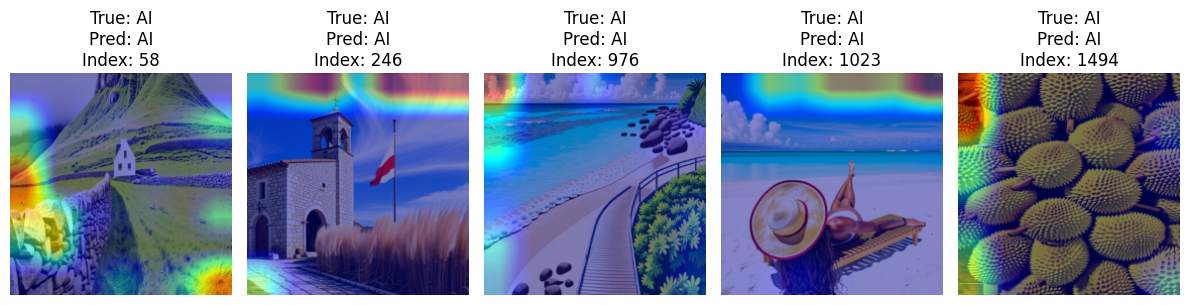

In [24]:
# GradCAM setup 
target_layers = [model.trunk_output.block4[-1]]
# target_layers = [model.trunk_output.block3]
cam = GradCAM(model=model, target_layers=target_layers)

plt.figure(figsize=(12, 3))
for i, (idx, image) in enumerate(sample_images_truly_ai):
    # input_tensor = (image.clone() - mean[:, None, None]) / std[:, None, None]  # normalize
    input_tensor = image.clone()
    input_tensor = input_tensor.unsqueeze(0)  # add batch dim

    target_category = int(all_predictions[idx])
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(target_category)])
    grayscale_cam = grayscale_cam[0, :]

    image_disp = image # * std[:, None, None] + mean[:, None, None]  # unnormalize
    image_disp = torch.clamp(image_disp, 0, 1).permute(1, 2, 0).numpy()

    visualization = show_cam_on_image(image_disp, grayscale_cam, use_rgb=True)
    plt.subplot(1, len(sample_images_truly_ai), i + 1)
    plt.imshow(visualization)
    plt.title(f"True: {classes[all_labels[idx]]}\nPred: {classes[all_predictions[idx]]}\nIndex: {idx}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Evaluate a model with template-based tests


FileNotFoundError: [Errno 2] No such file or directory: 'templates/food'

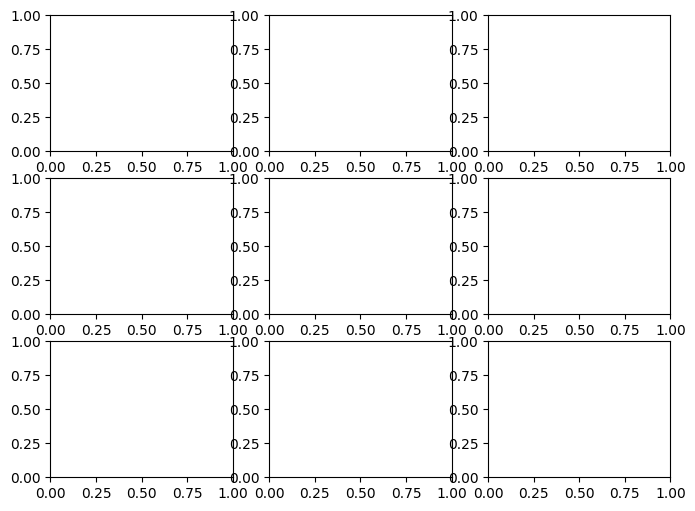

In [25]:
TEMPLATE_DIR = "templates"

fig, axes = plt.subplots(3, 3, figsize=(8, 6))

# Random food class
food_dir = os.path.join(TEMPLATE_DIR, "food")
food_classes = [d for d in os.listdir(food_dir) if os.listdir(os.path.join(food_dir, d))]
random_class = random.choice(food_classes)
food_images = random.sample(os.listdir(os.path.join(food_dir, random_class)), 3)
food_paths = [os.path.join(food_dir, random_class, f) for f in food_images]

for i, path in enumerate(food_paths):
    axes[0, i].imshow(Image.open(path))
    axes[0, i].set_title(f"Food ({random_class})")
    axes[0, i].axis("off")

# Backgrounds
bg_dir = os.path.join(TEMPLATE_DIR, "background")
bg_images = random.sample(os.listdir(bg_dir), 3)
bg_paths = [os.path.join(bg_dir, f) for f in bg_images]

for i, path in enumerate(bg_paths):
    axes[1, i].imshow(Image.open(path))
    axes[1, i].set_title("Background")
    axes[1, i].axis("off")

# Extras
extra_dir = os.path.join(TEMPLATE_DIR, "extras")
extra_images = random.sample(os.listdir(extra_dir), 3)
extra_paths = [os.path.join(extra_dir, f) for f in extra_images]

for i, path in enumerate(extra_paths):
    axes[2, i].imshow(Image.open(path))
    axes[2, i].set_title("Extra")
    axes[2, i].axis("off")

plt.tight_layout()
plt.show()


and, here is a function that can compose an image out of a background, a food item, and (optionally) an extra:

In [ ]:
# runs in jupyter container on node-eval-offline

def compose_image(food_path, bg_path=None, extra_path=None):

    food = Image.open(food_path).convert("RGBA")

    if bg_path:
        bg = Image.open(bg_path).convert("RGBA")
    else:
        bg = Image.new("RGBA", food.size, (255, 255, 255, 255))

    bg_w, bg_h = bg.size
    y_offset = int(bg_h * 0.05)
            
    food_scale = 0.5
    food = food.resize((int(bg_w * food_scale), int(bg_h * food_scale)))
    
    fd_w, fd_h = food.size

    if extra_path:
        
        extra_scale = 0.35
        extra = Image.open(extra_path).convert("RGBA")
        extra = extra.resize((int(bg_w * extra_scale), int(bg_h * extra_scale)))
        ex_w, ex_h = extra.size
        bg.paste(extra, (bg_w - ex_w, bg_h - ex_h - y_offset), extra)
        
    bg.paste(food, ((bg_w - fd_w) // 2, bg_h - fd_h - y_offset), food)

    return bg.convert("RGB")

Let’s try composing:

-   a food item
-   the same food item and background, with a background and an “extra”
-   the same food item, with a different background and different “extra”

These should all have the same prediction. Notice that this is a test we could even run on an *unlabeled* food item - we don’t need to know the actual class (although we do, in this case).

We can also try:

-   a different food item from the same class, on the same background - this should have the same predicted label
-   and a food item from a different class, on the same background - this should have a different predicted label

In [ ]:
# runs in jupyter container on node-eval-offline
imgs = {
    'original_image': compose_image('templates/food/09/001.png'),
    'composed_bg1_extra1': compose_image('templates/food/09/001.png', 'templates/background/001.jpg', 'templates/extras/spoon.png'),
    'composed_bg2_extra2': compose_image('templates/food/09/001.png', 'templates/background/002.jpg', 'templates/extras/fork.png'),
    'composed_same_class': compose_image('templates/food/09/002.png', 'templates/background/001.jpg'),
    'composed_diff_class': compose_image('templates/food/05/002.png', 'templates/background/001.jpg')
}

and, let’s look at these examples:

In [ ]:
# runs in jupyter container on node-eval-offline
fig, axes = plt.subplots(1, 5, figsize=(14, 3))

for ax, key in zip(axes, imgs.keys()):
    ax.imshow(imgs[key].resize((224,224)).crop((16, 16, 224, 224)))
    ax.set_title(f"{key}")
    ax.axis("off")

plt.tight_layout()
plt.show()

We can get the predictions of the model for these samples, as well as the GradCAM output -

In [ ]:
# runs in jupyter container on node-eval-offline

def predict(model, image, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    model.eval()
    image_tensor = val_test_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        output = model(image_tensor)
        return output.argmax(dim=1).item()


In [ ]:
# runs in jupyter container on node-eval-offline

fig, axes = plt.subplots(2, 5, figsize=(14, 6))

for i, key in enumerate(imgs.keys()):
    image_np = np.array(imgs[key].resize((224, 224))).astype(dtype=np.float32) / 255.0
    pred = predict(model, imgs[key])

    input_tensor = val_test_transform(imgs[key]).unsqueeze(0)
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred)])[0]
    vis = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

    axes[0, i].imshow(imgs[key].resize((224, 224)))
    axes[0, i].set_title(f"{key}\nPredicted: {pred} ({classes[pred]})")
    axes[0, i].axis("off")

    axes[1, i].imshow(vis)
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

That seemed OK - but let’s try it for a different combination of food item, background, and “extra” item:

In [ ]:
# runs in jupyter container on node-eval-offline

imgs = {
    'original_image': compose_image('templates/food/10/001.png'),
    'composed_bg1_extra1': compose_image('templates/food/10/001.png', 'templates/background/003.jpg', 'templates/extras/plastic_fork.png'),
    'composed_bg2_extra2': compose_image('templates/food/10/001.png', 'templates/background/002.jpg', 'templates/extras/fork.png'),
    'composed_same_class': compose_image('templates/food/10/002.png', 'templates/background/003.jpg'),
    'composed_diff_class': compose_image('templates/food/05/003.png', 'templates/background/003.jpg')
}


and repeat the visualization:

In [ ]:
# runs in jupyter container on node-eval-offline

fig, axes = plt.subplots(2, 5, figsize=(14, 6))

for i, key in enumerate(imgs.keys()):
    image_np = np.array(imgs[key].resize((224, 224))).astype(dtype=np.float32) / 255.0
    pred = predict(model, imgs[key])

    input_tensor = val_test_transform(imgs[key]).unsqueeze(0)
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred)])[0]
    vis = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

    axes[0, i].imshow(imgs[key].resize((224, 224)))
    axes[0, i].set_title(f"{key}\nPredicted: {pred} ({classes[pred]})")
    axes[0, i].axis("off")

    axes[1, i].imshow(vis)
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

Now we can see that our model is not nearly as robust as we might want it to be. We can see that some perturbations that should *not* change the model output do, and the model sometimes focuses on spurious items like the background or extra items that happen to be alongside the food in the image.

This type of test can be automated - we can collect a large number of food items, background, and “extras” and systematically evaluate this robustness as part of a test suite. We’ll get to that a little bit later, though.

### Evaluate a model on slices of interest

Next, let’s evaluate our model on slices of interest. This will help us understand:

-   if there is a fairness or bias issue in our model - if we evaluate the performance of the model on different groups, it will help us identify potential unfairness.
-   if our model is accurate enough on high-priority use cases.

For example, our model is reasonably accurate on “Dessert” samples. However, looking at some samples from this class:

In [ ]:
# runs in jupyter container on node-eval-offline
dessert_index = np.where(classes == "Dessert")[0][0]
dessert_images = []

for images, labels in test_loader:
    for img, label in zip(images, labels):
        if label.item() == dessert_index:
            dessert_images.append(img)
        if len(dessert_images) == 20:
            break
    if len(dessert_images) == 20:
        break

fig, axes = plt.subplots(4, 5, figsize=(10, 10))
for ax, img in zip(axes.flat, dessert_images):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = torch.clamp(img, 0, 1)
    ax.imshow(img.permute(1, 2, 0).numpy())
    ax.set_title("Dessert")
    ax.axis("off")

plt.tight_layout()
plt.show()

we can see that these are mostly Western-style desserts.

To evaluate whether our model is similarly effective at classifying food items from other cuisines, we might compile one or more test suites with non-Western food items. The images in the “indian_dessert” directory are also desserts -

In [ ]:
# runs in jupyter container on node-eval-offline

dessert_dir = "indian_dessert"
dessert_images = random.sample(os.listdir(dessert_dir), 5)
fig, axes = plt.subplots(1, 5, figsize=(10, 3))

for ax, img_name in zip(axes, dessert_images):
    path = os.path.join(dessert_dir, img_name)
    image = Image.open(path).convert("RGB")
    pred = predict(model, image)
    ax.imshow(image.resize((224, 224)).crop((16, 16, 224, 224)))
    ax.set_title(f"Predicted: {pred}\n({classes[pred]})")
    ax.axis("off")

plt.tight_layout()
plt.show()


but our model has much less predictive accuracy on *these* dessert samples.

### Evaluate a model on known failure modes

We might also consider evaluating a model on “known” failure modes - if a model has previously failed on a specific type of image, especially in a high-profile way, we will want to set up a test so that future versions of the model will be evaluated against this type of failure.

For example: Suppose that there is a trend on social media of making cakes that look like other items. This has been a high-profile failure for GourmetGram in the past, when users upload e.g. a photo of a cake that looks like (for example…) a stick of butter, and it is tagged as “Dairy product” instead of “Dessert”.

We could compile a set of test images related to this failure mode, and set it up as a separate test.

All of the photos in the “cake_looks_like” directory are actually photos of cake:

In [ ]:
# runs in jupyter container on node-eval-offline
cake_dir = "cake_looks_like"
cake_images = random.sample(os.listdir(cake_dir), 5)
fig, axes = plt.subplots(1, 5, figsize=(10, 3))

for ax, img_name in zip(axes, cake_images):
    path = os.path.join(cake_dir, img_name)
    image = Image.open(path).convert("RGB")
    pred = predict(model, image)
    ax.imshow(image.resize((224, 224)).crop((16, 16, 224, 224)))
    ax.set_title(f"{img_name}, Predicted: {pred}\n({classes[pred]})")
    ax.axis("off")

plt.tight_layout()
plt.show()

but, our model has a much lower accuracy on these samples than it did overall or on the general “Dessert” category.

### Create a test suite

Finally, let’s create a non-interactive test suite that we can run each time we re-train a model. We’ll use `pytest` as a unit test framework. Our test scripts are in “tests”. Open these Python files to review then.

Inside our “conftest.py”, we have some functions that are “fixtures”. These provide some shared context for the tests. We have defined:

-   `model`, which loads the saved model
-   `test_data`, which sets up the test data loader
-   `predictions`, which gets the model predictions on the test set
-   and we also define `predict` and `transform` functions so that we can use them throughout the test suite without having to repeat them in multiple files.

Then, we can pass `model`, `test_data`, and/or `predictions` to any of our test functions - these fixture functions will run only *once* and then provide their values to all test cases in a session. Similarly, we can pass `predict` to a test function and it will then be able to call our already-defined predict function.

Next, we have the test functions, which mirror what we have done in this notebook - but now, we have defined criteria for passing. A test function raises an exception if the criteria for passing are not met:

-   `test_overall_accuracy` passes if the overall accuracy is greater than 85%
-   `test_per_class_accuracy` passes if accuracy is greater than 75% for every individual class
-   `test_template_permutations` generates combinations of “composed” images using the template: food item, extra item, and background. It passes if 80% are predicted correctly.
-   `test_cake_looks_like_accuracy` and `test_indian_dessert_accuracy` each pass if accuracy is greater than 60% on the corresponding sets of images.

Of course, in a realistic setting, we would have a more comprehensive series of tests (e.g. we would have many more templates; we would evaluate the model on other forms of non-Western cuisine and not only Indian desserts, etc.). This is just a demonstration of how these tests would be automated.

Once we have defined these tests, we can run our test suite with:

In [ ]:
# runs in jupyter container on node-eval-offline
!pytest --verbose --tb=no tests/

where:

-   `--verbose` will report the result of every test, not just the ones that fail
-   `--tb=no` says not to print a traceback for every failed test
-   and `pytest` will automatically discover and run every function that starts with `test_` in this directory

We have only scratched the surface with `pytest`. For example, we can re-run the tests that failed in the last run with `--lf`:

In [ ]:
# runs in jupyter container on node-eval-offline
!pytest --verbose --lf --tb=no tests/

or we can run only the tests from a particular test file:

In [ ]:
# runs in jupyter container on node-eval-offline
!pytest --verbose --tb=no tests/test_food11_test_cases.py

You can learn more about its capabilities in its [documentation](https://docs.pytest.org/en/stable/index.html).

------------------------------------------------------------------------

When you are finished with this section - save and then download the fully executed notebook from the Jupyter container environment for later reference. (Note: because it is an executable file, and you are downloading it from a site that is not secured with HTTPS, you may have to explicitly confirm the download in some browsers.)